In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
# https://www.kaggle.com/erenaktas/human-activity-recognition
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

File ‘UCI-HAR.zip’ already there; not retrieving.



In [3]:
!unzip -nq UCI-HAR.zip

In [4]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [5]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x

  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1 # since labels are from 1 - 6 while python3 is 0 indexed
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

In [6]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

/tmp/ipython-input-2941258151.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2941258151.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2941258151.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2941258151.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-2941258151.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/

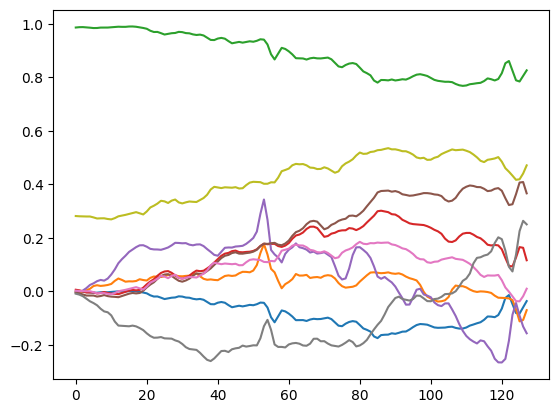

In [7]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [8]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i) # 32 feature maps , filter size 5 : by default convolution is in "valid" mode
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x) # 64 feature maps: note number of feature maps is increasing
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x) # 128 feature maps: note number of feature maps is increasing
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [9]:
model.summary()
'''
by default convolution is in "valid" mode, so:
In first convolution when size 5 filter acts on 128 size input, output is of size 128 - 5  + 1 = 124
In second convolution when size 3 filter acts on 41 size input, output is of size 41 - 3 + 1 = 39
In third convolution when size 3 filter acts on 19 size input, output is of size 19 - 3 + 1 = 17
'''
'''
Number of parameters at first convolution:
  Number of feature maps = 32 and filter size = 5
  Number of bias parameters = Number of feature maps = 32
  Number of non-bias parameters = Number of Number of feature maps * filter size * number of dimensions in time series
                                = 32 * 5 * 9 = 1440
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 32 + 1440 = 1472
'''
'''
Number of parameters at second convolution:
  Number of feature maps = 64 and filter size = 3
  Number of bias parameters = Number of feature maps = 64
  Number of non-bias parameters = Number of Number of feature maps * filter size * number of dimensions in time series
                                = 64 * 3 * 32 = 6144
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 64 + 6144 = 6208
'''
'''
Number of parameters at second convolution:
  Number of feature maps = 128 and filter size = 3
  Number of bias parameters = Number of feature maps = 128
  Number of non-bias parameters = Number of Number of feature maps * filter size * number of dimensions in time series
                                = 128 * 3 * 64 = 24576
Number of total parameters = Number of bias parameters + Number of non-bias parameters = 128 + 24576 = 24704
'''

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 124, 32)        │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 41, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,158 (129.52 KB)

 Trainable params: 33,158 (129.52 KB)

 Non-trainable params: 0 (0.00 B)

'\nNumber of parameters at second convolution: \n  Number of feature maps = 128 and filter size = 3\n  Number of bias parameters = Number of feature maps = 128\n  Number of non-bias parameters = Number of Number of feature maps * filter size * number of dimensions in time series\n                                = 128 * 3 * 64 = 24576\nNumber of total parameters = Number of bias parameters + Number of non-bias parameters = 128 + 24576 = 24704\n'

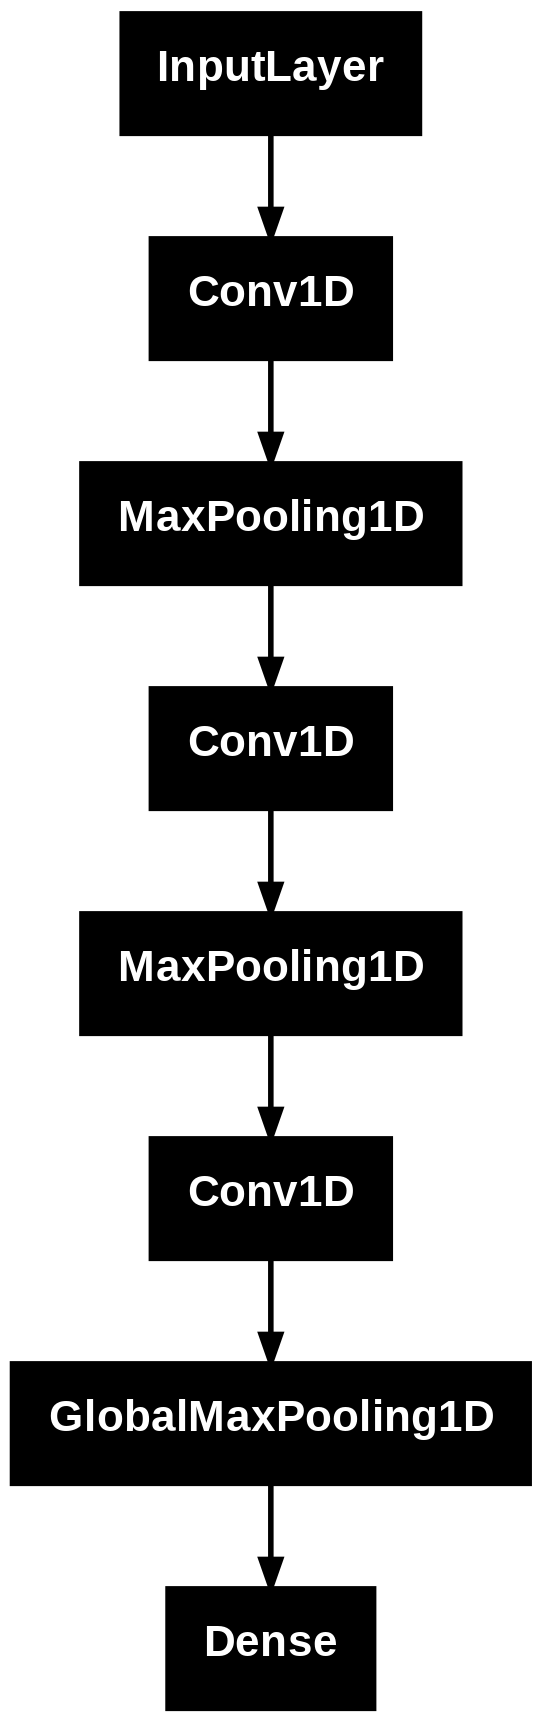

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

In [12]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),#from_logits=True because we didn't apply SOFTMAX in Dense layer for numerical stability reasons
  optimizer='adam',
  metrics=['accuracy'],
)

In [13]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7060 - loss: 0.8111

230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7088 - loss: 0.8041 - val_accuracy: 0.9077 - val_loss: 0.2356
Epoch 2/15
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9458 - loss: 0.1315

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9458 - loss: 0.1314 - val_accuracy: 0.9148 - val_loss: 0.2195
Epoch 3/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9520 - loss: 0.1149

230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9520 - loss: 0.1149 - val_accuracy: 0.9169 - val_loss: 0.2059
Epoch 4/15
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9562 - loss: 0.1065

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9563 - loss: 0.1064 - val_accuracy: 0.9196 - val_loss: 0.1919
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9580 - loss: 0.0990 - val_accuracy: 0.9186 - val_loss: 0.1878
Epoch 6/15
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9611 - loss: 0.0931

230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9611 - loss: 0.0931 - val_accuracy: 0.9220 - val_loss: 0.1921
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9617 - loss: 0.0873 - val_accuracy: 0.9216 - val_loss: 0.1998
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9643 - loss: 0.0810

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9644 - loss: 0.0810 - val_accuracy: 0.9230 - val_loss: 0.2102
Epoch 9/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9681 - loss: 0.0762

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9681 - loss: 0.0762 - val_accuracy: 0.9257 - val_loss: 0.2133
Epoch 10/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9691 - loss: 0.0745

230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9691 - loss: 0.0745 - val_accuracy: 0.9267 - val_loss: 0.2347
Epoch 11/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9726 - loss: 0.0630

230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9726 - loss: 0.0630 - val_accuracy: 0.9308 - val_loss: 0.2435
Epoch 12/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9744 - loss: 0.0564

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9744 - loss: 0.0564 - val_accuracy: 0.9372 - val_loss: 0.2501
Epoch 13/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9780 - loss: 0.0506

230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9781 - loss: 0.0506 - val_accuracy: 0.9389 - val_loss: 0.2600
Epoch 14/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9797 - loss: 0.0458 - val_accuracy: 0.9386 - val_loss: 0.2725
Epoch 15/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9809 - loss: 0.0417

230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9809 - loss: 0.0417 - val_accuracy: 0.9393 - val_loss: 0.2881


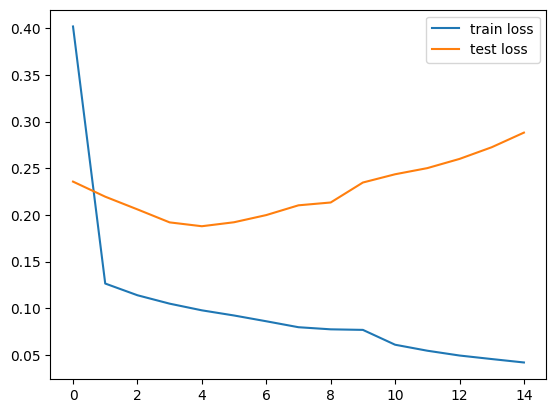

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

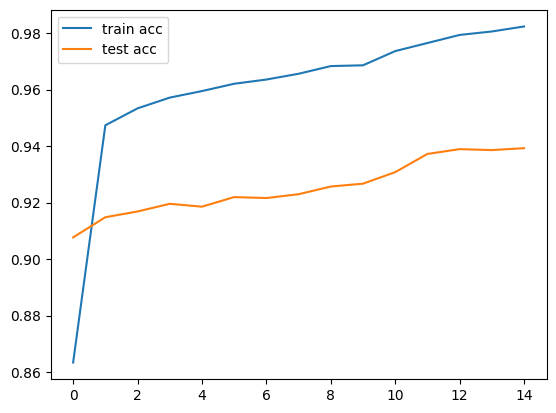

In [15]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [16]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [17]:
# make predictions
Ptest = best_model.predict(Xtest)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [18]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

np.float64(0.9392602646759416)

In [19]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)

  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [20]:
feat_train, feat_test = load_features()

/tmp/ipython-input-3714720902.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-3714720902.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [21]:
D_feat = feat_train.shape[1]

In [22]:
# Combined Model

# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

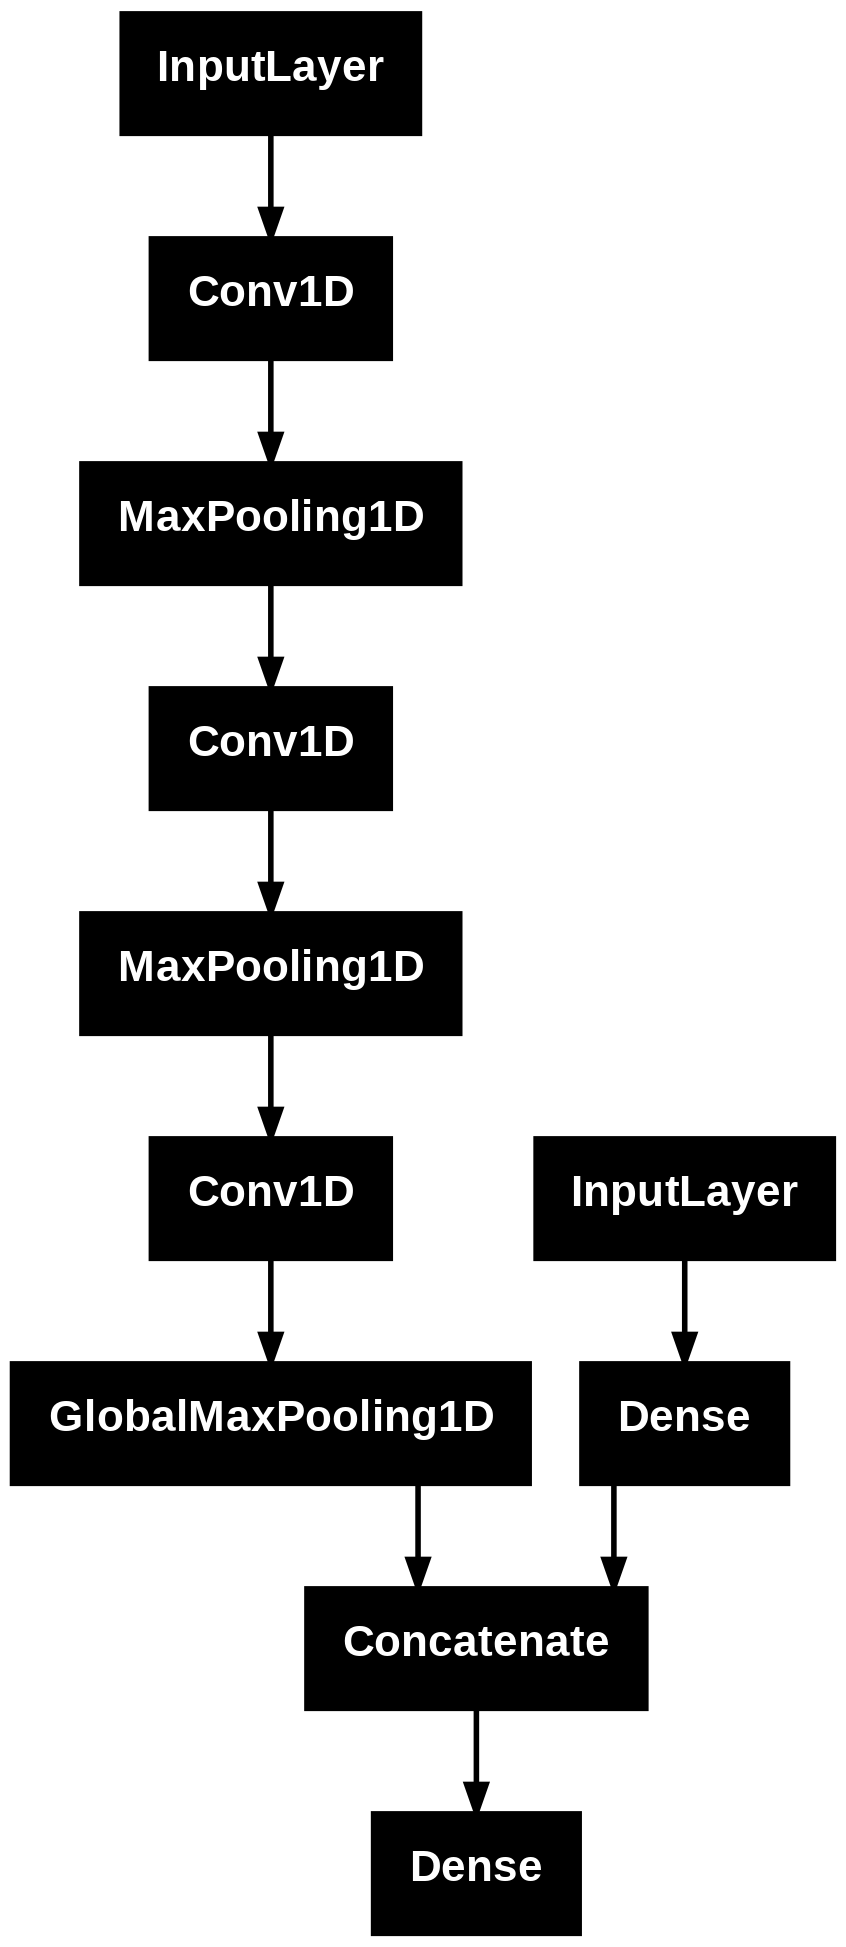

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [25]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),#from_logits=True because we didn't apply SOFTMAX in Dense layer for numerical stability reasons
  optimizer='adam',
  metrics=['accuracy'],
)

In [26]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point3],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8050 - loss: 0.4804

230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8064 - loss: 0.4771 - val_accuracy: 0.9464 - val_loss: 0.1340
Epoch 2/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9667 - loss: 0.0807

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9668 - loss: 0.0805 - val_accuracy: 0.9532 - val_loss: 0.1137
Epoch 3/15
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9762 - loss: 0.0569

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9763 - loss: 0.0568 - val_accuracy: 0.9579 - val_loss: 0.1120
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9807 - loss: 0.0459

230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9807 - loss: 0.0459 - val_accuracy: 0.9589 - val_loss: 0.1133
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9842 - loss: 0.0396 - val_accuracy: 0.9586 - val_loss: 0.1182
Epoch 6/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9882 - loss: 0.0352

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9882 - loss: 0.0351 - val_accuracy: 0.9593 - val_loss: 0.1183
Epoch 7/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9897 - loss: 0.0313

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9897 - loss: 0.0313 - val_accuracy: 0.9603 - val_loss: 0.1200
Epoch 8/15
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9893 - loss: 0.0353

230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9664 - val_loss: 0.1087
Epoch 9/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9903 - loss: 0.0254 - val_accuracy: 0.9634 - val_loss: 0.1194
Epoch 10/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9915 - loss: 0.0229 - val_accuracy: 0.9610 - val_loss: 0.1250
Epoch 11/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9930 - loss: 0.0203 - val_accuracy: 0.9583 - val_loss: 0.1395
Epoch 12/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9933 - loss: 0.0181 - val_accuracy: 0.9535 - val_loss: 0.1563
Epoch 13/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9940 - loss: 0.0159 - val_accuracy: 0.9532 - val_loss: 0.1695
Epoch 14/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9947 - loss: 0.0146 - val_accuracy: 0.9535 - val_loss: 0.1750
Epoch 15/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9958 - loss: 0.0142 - val_accuracy:

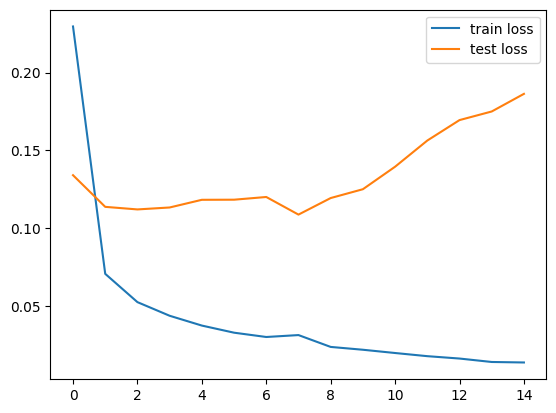

In [27]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

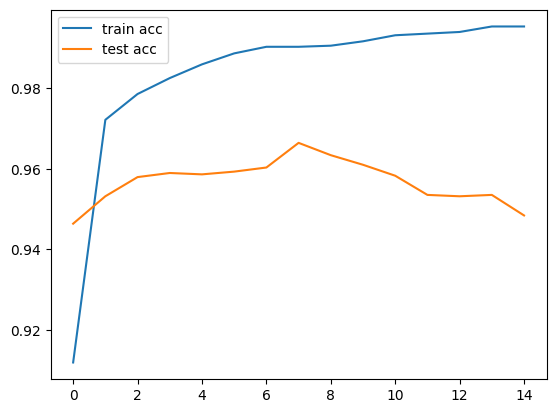

In [28]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [29]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [30]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [31]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

np.float64(0.9664065151001018)